In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
mat_contents = scipy.io.loadmat(os.path.join('.','allFaces.mat'))
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])
training_faces = faces[:,:np.sum(nfaces[:36])]

In [18]:
average_face = np.mean(training_faces,axis=1)
normalized_faces = training_faces - np.tile(average_face,(faces.shape[1],1)).T

In [20]:
def reduced_svd(A):
  '''
  Input: any matrix A
  Returns: tuple of matrix U, array of singular values and matrix V.T 
  '''
  # your code here
  rank_of_A = np.linalg.matrix_rank(A)

  symmetric_matrix_V = A.T @ A

  eigenvalues_V, eigenvectors_V = np.linalg.eigh(symmetric_matrix_V)
  eigenvalues_V[eigenvalues_V < 0] = 0

  idx = np.argsort(eigenvalues_V)[::-1]   
  V = eigenvectors_V[:,idx]
  V = V[:,:rank_of_A]
  
  sigma = np.sort(np.sqrt(eigenvalues_V))[::-1]
  sigma = sigma[:rank_of_A]
  U = (A @ V) @ np.linalg.inv(np.diag(sigma))
  return U, sigma, V.T

U, sigma, VT = reduced_svd(normalized_faces)
print(U.shape)
print(sigma.shape)
print(VT.shape)

(32256, 2281)
(2281,)
(2281, 2282)


NameError: name 'avgFace' is not defined

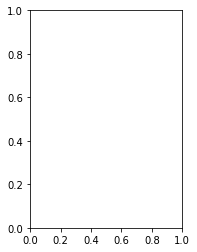

In [21]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(averageace,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,0],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

plt.show()